# 폐렴 예측하기

[캐글의 Chest X-Ray Images](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) 데이터셋을 통해 폐렴을 판단하려한다.

## 라이브러리 불러오기

In [ ]:
import tensorflow as tf
import numpy as np
tf.random.set_seed(1111)
np.random.seed(1111)

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import glob
import os
import time

## 데이터 불러오기

다음과 같은 폴더 구성으로 데이터를 가지고 있을 때 [`tfds`의 `ImageFolder`](https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder) 객체를 사용하면 손쉽게 학습을 위한 데이터를 준비할 수 있다.
```bash
.
├── test
│   ├── NORMAL
│   └── PNEUMONIA
├── train
│   ├── NORMAL
│   └── PNEUMONIA
└── val
    ├── NORMAL
    └── PNEUMONIA
```

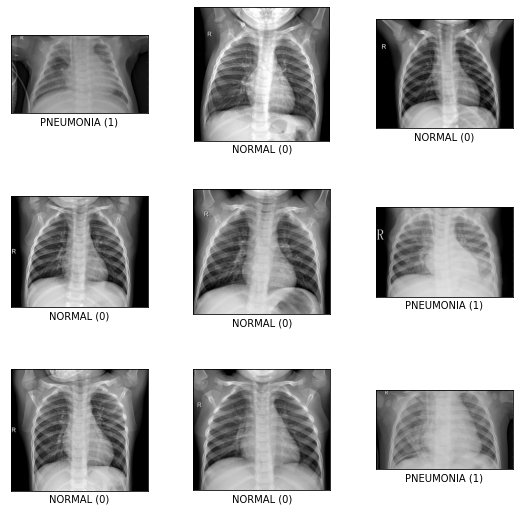

'Train 데이터 수 : 5216, Test 데이터 수 : 624'

In [2]:
builder = tfds.folder_dataset.ImageFolder('data')

train_ds, val_ds, test_ds = builder.as_dataset(split=['train', 'val', 'test'], shuffle_files=True, as_supervised=True)
train_ds.concatenate(val_ds)

tfds.show_examples(train_ds, builder.info)
f"Train 데이터 수 : {len(train_ds)}, Test 데이터 수 : {len(test_ds)}"

<br/>

## 데이터 전처리

기본적인 전처리로 이미지 Resize를 진행해주었다.

In [3]:
IMAGE_SIZE = [180, 180]

def preprocessing(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, label

train_ds = train_ds.map(preprocessing)
test_ds = test_ds.map(preprocessing)

for image, label in train_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  1


<br/>

## 모델 정의하기

In [4]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

<br/>

**Weight Unbalancing Problem**<br/>
2가지 카테고리를 분류하는 분류문제인데, 2가지 카테고리간의 데이터 불균형이 있다. 이를 해결하기 위한 기법으로 `class_weight `를 계산하여 데이터가 많은 데이터에 더 많은 Loss를 준다.

In [5]:
TRAIN_IMG_COUNT = len(train_ds)
COUNT_NORMAL = sum([1 for x, y in train_ds if y == 0])
COUNT_PNEUMONIA = sum([1 for x, y in train_ds if y == 1])

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [6]:
len(train_ds)

5216

Train ds가 5216개의 데이터를 가지고 있어서 대략 1000개를 validation data로 사용하고 나머지 4216개를 Train data로 사용하였다.

In [7]:
val_ds = train_ds.take(1000)
train_ds = train_ds.skip(1000)

Model 클래스의 Props로 `argumentation`, `ratio`를 추가해주었다.

Argumentation의 경우 Bool 값을 가지고 True일 경우 argumentation block을 모델에 추가한다.<br/>
ratio의 경우 모델의 주요 Output Dims의 값들을 Scaling 하는 파라미터이다.

In [8]:
from tensorflow.keras import layers, Input

class MyModel(tf.keras.Model):
    
    def __init__(self, argumentation=False, ratio=1):
        super(MyModel, self).__init__()
        
        self.img_size = 180
        
        self.argumentation = argumentation
        self.ratio = ratio
        self.model = self.build_model()
        
    def call(self, x):
        return self.model(x)
    
    def build_model(self):
        model = tf.keras.Sequential()
        model.add(Input(shape=(self.img_size, self.img_size, 3)))
        if self.argumentation:
            model.add(self.argumentation_block())
        
        model.add(layers.Conv2D(16, 3, activation='relu', padding='same'))
        model.add(layers.Conv2D(16, 3, activation='relu', padding='same'))
        model.add(layers.MaxPool2D()),
        
        model.add(self.conv_block(32 // self.ratio))
        model.add(self.conv_block(64 // self.ratio))
        model.add(self.conv_block(128 // self.ratio))
        model.add(layers.Dropout(0.2))
        model.add(self.conv_block(256 // self.ratio))
        model.add(layers.Dropout(0.2))
        
        model.add(layers.Flatten())
        
        model.add(self.dense_block(512 // self.ratio, 0.7))
        model.add(self.dense_block(128 // self.ratio, 0.5))
        model.add(self.dense_block(64 // self.ratio, 0.3))
        
        model.add(layers.Dense(1, activation='sigmoid'))
        
        return model
    
    def conv_block(self, filters):
        block = tf.keras.Sequential([
            tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
            tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D()
        ])
        return block
    
    def dense_block(self, units, dropout_rate):
        block = tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        return block
    
    def argumentation_block(self):
        return tf.keras.Sequential([
            layers.experimental.preprocessing.RandomFlip("horizontal")
        ])

4가지 모델의 정의하였다

- Basic
- Argumentation
- Model size % 2
- Model size * 2

In [9]:
basic_model = MyModel()

basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [10]:
argumentation_model = MyModel(argumentation=True)

argumentation_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [11]:
light_model = MyModel(ratio=2)

light_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [12]:
heavy_model = MyModel(ratio=0.5)

heavy_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [13]:
EPOCHS = 25
basic_history = basic_model.fit(
    train_ds.batch(32),
    epochs=EPOCHS,
    validation_data=val_ds.batch(32),
    class_weight=class_weight,
)
argumentation_history = argumentation_model.fit(
    train_ds.batch(32),
    epochs=EPOCHS,
    validation_data=val_ds.batch(32),
    class_weight=class_weight,
)
light_history = light_model.fit(
    train_ds.batch(32),
    epochs=EPOCHS,
    validation_data=val_ds.batch(32),
    class_weight=class_weight,
)
heavy_history = heavy_model.fit(
    train_ds.batch(32),
    epochs=EPOCHS,
    validation_data=val_ds.batch(32),
    class_weight=class_weight,
)

Epoch 1/25
132/132 [==============================] - 61s 336ms/step - loss: 0.4970 - accuracy: 0.7558 - precision: 0.9317 - recall: 0.7167 - val_loss: 0.5980 - val_accuracy: 0.7550 - val_precision: 0.7550 - val_recall: 1.0000
Epoch 2/25
132/132 [==============================] - 28s 202ms/step - loss: 0.2215 - accuracy: 0.9142 - precision: 0.9693 - recall: 0.9126 - val_loss: 1.0456 - val_accuracy: 0.7410 - val_precision: 0.7410 - val_recall: 1.0000
Epoch 3/25
132/132 [==============================] - 28s 202ms/step - loss: 0.1528 - accuracy: 0.9368 - precision: 0.9858 - recall: 0.9286 - val_loss: 1.2630 - val_accuracy: 0.7600 - val_precision: 0.7600 - val_recall: 1.0000
Epoch 4/25
132/132 [==============================] - 28s 202ms/step - loss: 0.1290 - accuracy: 0.9507 - precision: 0.9811 - recall: 0.9529 - val_loss: 1.0909 - val_accuracy: 0.7670 - val_precision: 0.7670 - val_recall: 1.0000
Epoch 5/25
132/132 [==============================] - 28s 203ms/step - loss: 0.1335 - accura

In [14]:
def draw_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title(met)
        ax[i].set_xlabel('epochs')
        ax[i].legend(['train', 'val'])
    plt.show()

Nothing


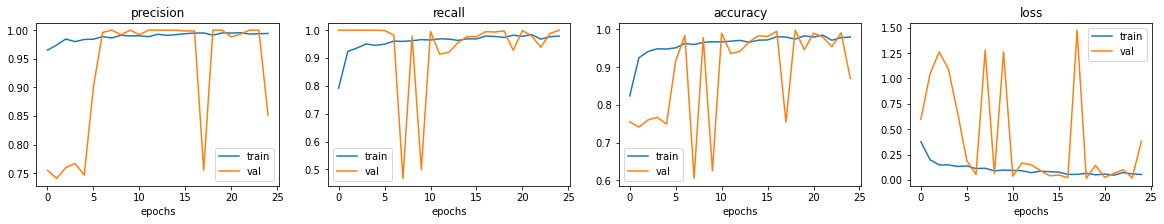

Data Arguementation


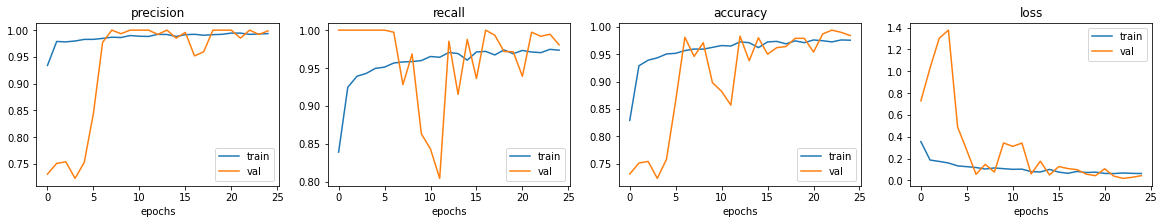

Model Size % 2


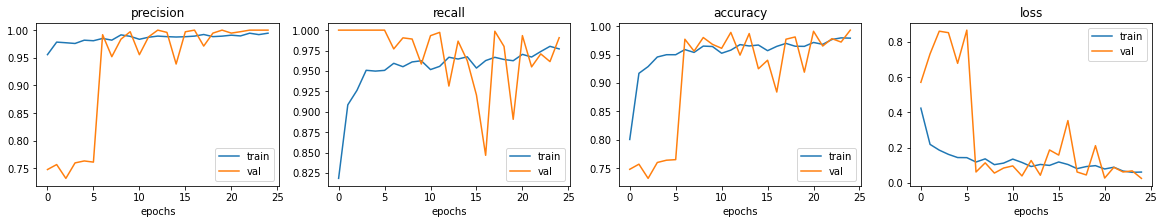

Model Size X 2


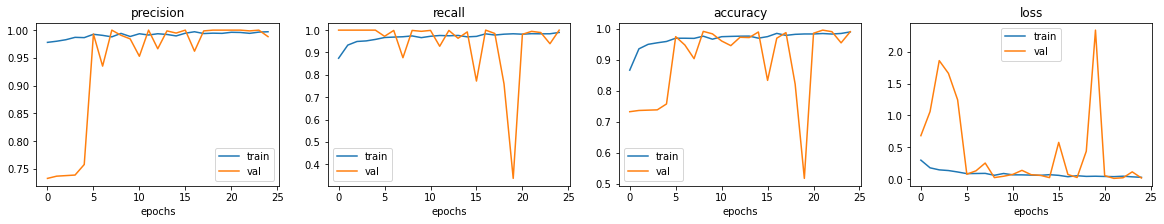

In [15]:
print("Nothing")
draw_history(basic_history)
print("Data Arguementation")
draw_history(argumentation_history)
print("Model Size % 2")
draw_history(light_history)
print("Model Size X 2")
draw_history(heavy_history)

## 결론

4가지 모델을 비교해보았다. 기존의 모델에 Argumentation을 추가하고, 전체적으로 모델 사이즈를 줄이고 늘리는 등의 Hyper Parameter Tuning을 진행해보았는데, 안정적으로 잘 학습이 되는 모델은 Data Argumentation을 추가한 모델이다. 